# Setting up our Notebook

In this notebook, the setup and exploration of the environment heavily follows Nicholas Renotte's YouTube tutorial *Build an Mario AI Model with Python | Gaming Reinforcement Learning* at: https://www.youtube.com/watch?v=2eeYqJ0uBKE&t=1982s

The implementation of the DQN algorithm is a modified version of the example script found in *Deep Reinforcement Learning with Python*.

Pertinent Links:

Super Mario RL: https://pypi.org/project/gym-super-mario-bros/

Nes Py: https://pypi.org/project/nes-py/

OpenAI Gym: https://gym.openai.com/

In [1]:
# Standard Imports
import random
import numpy as np
import matplotlib.pyplot as plt

# RL
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
import gym
import numpy as np
import seaborn_image as isns
from scipy.signal import convolve, gaussian
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms as T

# Misc
import os
import io
import base64
import time
import glob
from PIL import Image
# from IPython.display import HTML

In [2]:
# Import the game
import gym_super_mario_bros

# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace # Needed for changing the action space

# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

# Misc
from gym.spaces import Box
from gym.wrappers import FrameStack

# Mathematical Description of a Deep Q-Network

Recall the equation for Q-Learning:

$$ Q(S_t,A_t)=Q(S_t,A_t)+\alpha \left[ R_{t+1}+\gamma \max_{A_{t+1}} Q(S_{t+1},A_{t+1})-Q(S_t,A_t) \right]$$

However, we will be using neural networks to approximate our $Q$-function. We denote the weights and biases of this neural network $\bf{\Theta}$, and our approximation is thus:

$$Q^{\pi}(s,a) \approx {\hat{Q}}(s,a, \bf{\Theta})$$.

We can calculate the loss as the difference squared between the true or target $Q$-function and the appoximation, in Monte Carlo form, as:

$$ {\mathcal{L}}({\bf{\Theta}})=\dfrac{1}{N}\sum_{i=1}^{N}(Q^{\pi}(s,a) - {\hat{Q}}(s,a, {\bf{\Theta}}))^2$$

We use gradient descent to update our parameters $\bf{\Theta}$:

$${\bf{\Theta}}_{t+1}={\bf{\Theta}}_t-\alpha \nabla _{{\bf{\Theta}}_t} {\mathcal{L}}({\bf{\Theta}}_t)$$

However, unlike in normal supervised machine learning, we do not actually know the true function $Q^{\pi}$, so we must approximate it. We do so with another set of weights, ${\bf{\Theta}}^{target}$.

Our new target function is thus:

$$Q^{\pi}(s_i,a_i)=r_i+(1-done_i)\gamma \max_{{a_i}^{'}} {\tilde{Q}}({s_i}^{'},{a_i}^{'},{\bf{\Theta}}^{target}_t)$$

Finally, our parameter update equation, fully wirtten out, becomes:

$${\bf{\Theta}}_{t+1}={\bf{\Theta}}_t +\alpha \dfrac{1}{N}\sum_{i=1}^{N} \left[ r_i+(1-done_i) \gamma \max_{{a_i}^{'}} {\tilde{Q}}({s_i}^{'},{a_i}^{'},{\bf{\Theta}}^{target}_t)-{\hat{Q}}(s_i,a_i, {\bf{\Theta}}_t) \right] \nabla _{{\bf{\Theta}}_t}  {\hat{Q}}(s_i,a_i, {\bf{\Theta}}_t)$$


Our target parameters, ${\bf{\Theta}}^{target}$ are then updated less often so they serve as a stationary target for our loss function.

## Mathematical Description of a Double Deep Q-Network

In a Double Deep Q-Network, the only thing that changes is the target. Recall the target Q-network in DQN:

$$Y^{target}_{DQN}=r_i+(1-done_i)\gamma \max_{{a_i}^{'}} {\tilde{Q}}({s_i}^{'},{a_i}^{'},{\bf{\Theta}}^{target}_t)$$

We will modify this slightly by choosing the next action to be the one that maximizes the $\hat{Q}$, and then feed that into the $\tilde{Q}$ function. This looks like:

$$Y^{target}_{DDQN}=r_i+(1-done_i)\gamma {\tilde{Q}}({s_i}^{'},\max_{{a_i}^{'}} {\hat{Q}}({s_i}^{'},{a_i}^{'},{\bf{\Theta}}_t) ,{\bf{\Theta}}^{target}_t)$$

## Mathematical Description of a Dueling Deep Q-Network

In this modification, we will begin by defining the Advantage:

$$ A^{\pi} (s,a)=Q^{\pi}(s,a)-V(s)^{\pi}$$

From here, we will divide our neural network up and calculate the $Q$-value as follows:

<img src="Graphics/Dueling DQN.png" width="600" height="600" />

# Exploring the game

In [3]:
# Setting up the game

env = gym_super_mario_bros.make('SuperMarioBros-v0')

In [4]:
# Exploring the types of movement

print('The RIGHT_ONLY action space:', RIGHT_ONLY)
print('\n')
print('The SIMPLE_ACTION action space:', SIMPLE_MOVEMENT)
print('\n')
print('The COMPLEX_ACTION action space:', COMPLEX_MOVEMENT)

The RIGHT_ONLY action space: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B']]


The SIMPLE_ACTION action space: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]


The COMPLEX_ACTION action space: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left'], ['left', 'A'], ['left', 'B'], ['left', 'A', 'B'], ['down'], ['up']]


In [5]:
# Exploring the observation space

env.observation_space.shape

(240, 256, 3)

In [6]:
# Exploring the action space

env.action_space

Discrete(256)

So, we have each frame being 240 $\times$ 256 pixels with 3 channnels (RBG).

Let's choose the simple movements for ease of training.

## Random Actions

In [7]:
# Taking random actions

def random_actions(game, movement, num_actions, render):
    
    """
    game is the game name.
    movements is the type of movement where there are options. 'None' will skip this.
    num_actions is the number of steps.
    render determines if the game will be displayed, determined with True
    """
    rewards = []
    done = True
    env = gym_super_mario_bros.make(game)
    if movement != 'None':
        env = JoypadSpace(env, movement)

    # Loop through each frame in the game
    for step in range(num_actions): 
        # Start the game to begin with 
        if done == True: 
            env.reset()
        # Do random actions
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if render == True:
            env.render()
        rewards.append(reward)
         
    # Close the game and return the rewards
    env.close()
    return np.sum(rewards)
    
    # Close the game
    env.close()

In [8]:
print('The reward in this trajectory is:', random_actions('SuperMarioBros-v0', SIMPLE_MOVEMENT, 10, False))

The reward in this trajectory is: 3


# Preprocessing the Environment

In [9]:
# Importing wrappers

# Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

In [10]:
def set_up_env(game, movement, grayscale, frame_stacking, frames, order):

    env = gym_super_mario_bros.make(game)
    env = JoypadSpace(env, movement)
    if grayscale == True:
        env = GrayScaleObservation(env, keep_dim=True)
    env = DummyVecEnv([lambda: env])
    if frame_stacking == True:
        env = VecFrameStack(env, frames, channels_order=order)
        
    return env

### Exploring what the GrayScaleObservation and VecFrameStack do

#### VecFrameStack and GrayScaleObservation turned off

In [11]:
env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, False, False, 4, 'last')

State Shape (1, 240, 256, 3)


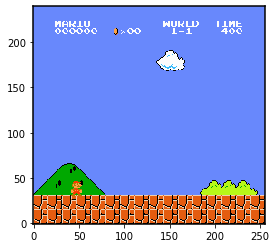

In [12]:
state = env.reset()
print('State Shape', state.shape)
plt.imshow(state[0]).origin='upper'

#### GrayScaleObservation Off and VecFrameStack On

In [13]:
env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, False, True, 4, 'last')

State Shape (1, 240, 256, 12)


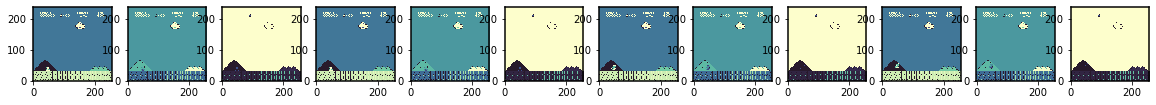

In [14]:
state = env.reset()
print('State Shape', state.shape)
for i in range(0,4): # Filling our vector with images
    state, reward, done, info = env.step([env.action_space.sample()]) # Note that the brackets around the env.action... are
# because we have wrapped it

plt.figure(figsize=(20,20))
for idx in range(12): # So there'll be 4 images with 3 channels
    plt.subplot(1,12,idx+1)
    plt.imshow(state[0][:,:,idx]).origin='upper' # idx is in ranging through 1-4
    plt.show

#### GrayScaleObservation and VecFrameStack On

In [15]:
env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, True, True, 4, 'last')

State Shape (1, 240, 256, 4)


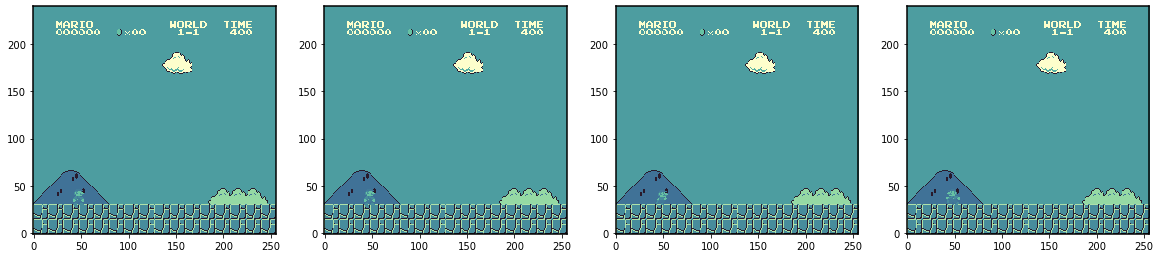

In [16]:
state = env.reset()
print('State Shape', state.shape)
for i in range(0,4): # Filling our vector with images
    state, reward, done, info = env.step([env.action_space.sample()]) # Note that the brackets around the env.action... are
# because we have wrapped it

plt.figure(figsize=(20,20))
for idx in range(state.shape[3]): # So there'll be 4 images
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx]).origin='upper' # idx is in ranging through 1-4
    plt.show

# Setting up our Dueling Double DQN with PER

In [17]:
# Getting the observation and action shape for our neural net

env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, True, True, 4, 'last')

state_shape, n_actions = env.observation_space.shape, env.action_space.n
state_dim = state_shape
print('State Shape:', state_dim)
print('Number of actions:',n_actions)

State Shape: (240, 256, 4)
Number of actions: 7


## Setting up the device

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [19]:
# Creating the Dueling DQN Agent

class DuelingDQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon = 0.5):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        
        self.conv = nn.Sequential(nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=8, stride=4),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten())
        self.value = nn.Sequential(nn.Linear(288, 1))
        self.adv = nn.Sequential(nn.Linear(288, n_actions))
        
    def forward(self, state_t):
        x = self.conv(state_t)
        v = self.value(x)
        adv = self.adv(x)
        adv_avg = torch.mean(adv, dim=1, keepdim=True)
        qvalues = v + adv - adv_avg
        return qvalues

    def get_qvalues(self, states):
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        # Sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [20]:
# Instantiation of the agent

agent = DuelingDQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [21]:
state = env.reset()

def reorder_state(state):
    state = torch.tensor(state, device=device, dtype=torch.float32)
    state = torch.squeeze(state)
    state = state.transpose(0,2)
    state = state.transpose(1,2)
    state = state.unsqueeze(0)
    
    return state
    
state = reorder_state(state)
state.shape

torch.Size([1, 4, 240, 256])

## Prioritized Experience Replay

### Mathematical Description of Prioritized Experience Replay

Replay buffer is very important in DQN to break the correlation between samples. We use a behavior policy ($\epsilon-greedy$) to sample from the environment and store the transitions $(s,a,r,s',done)$ into a buffer. These samples are used multiple times in a learning making the process sample efficient. 

We will be using prioritized version of experience replay. 

The interface to PrioritizedReplayBuffer is:
* `exp_replay.add(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns states, actions, rewards, next_states and done_flags for `batch_size` random samples.
* `update_priorities(idxs, new_priorities)` - returns nothing. 
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In usual replay buffer, we select training batch with equal probability of selection for each sample/transition stored in the buffer. However, in Prioritized replay, we assign an importance score $p_i$ to each sample/transition. One approach to importance score is to use the absolute value of TD error $\delta_i$ with addition of small constant $\epsilon$ to avoid the edge case of error being zero and not picked up again ever.  

$$ p_i = |\delta_i| +\epsilon$$

$$\delta_i = r_i + \left[ (1-done_i)  \gamma   \max_{a_i^{'}} \tilde{Q}(s_{i}^{'},a_i^{'},{\bf{\Theta}}^{target}_t) \right] – \hat{Q}(s_i,a_i,{\bf{\Theta}}_t)$$

Note: We have the regular DQN error written above, but when combining the Double DQN and PER, this error will change to accomodate the changes in the Double DQN.

At the time of picking the batch samples from buffer, the individual importance scores for samples are converted to probability which defines the probability of a sample being picked:

$$P(i) = \frac{p_i^{\alpha}}{\sum_i p_i^{\alpha}}$$

$\alpha$ is a hyper parameter and in the paper in which this method was developed, a value of 0.6 was found to work the best. We are using the same value in our code here.

TD error for the samples chosen in the batch is used to calculate the loss and $\nabla_w(L)$. The TD error is also used to update the importance score $p_i$ of the samples back in the buffer. 

The probability $P(i)$ is also used to calculate a weight, an importance sampling value, to adjust for the fact that samples now have a non uniform probability of being picked. The weight vector for batch samples as given below:

$$w_i = \left(\frac{1}{N}\frac{1}{P(i)} \right)^\beta$$

The value of $\beta=0.4$ has been taken from the paper in which this was originally implemented, same as with $\alpha$.

Now, we normalize our weight:

$$w_i=\dfrac{1}{\max_{i} w_i} w_i$$

Finally, our loss function is now:

$${\mathcal{L}}({\bf{\Theta}}_t, {\bf{\Theta}}^{target}_t)= \dfrac{1}{N}\sum_{i=1}^{N} \left[ \left( r_i+[(1-done_i) \gamma \max_{{a_i}^{'}} {\tilde{Q}}({s_i}^{'},{a_i}^{'},{\bf{\Theta}}^{target}_t)]-{\hat{Q}}(s_i,a_i, {\bf{\Theta}}_t) \right) w_i \right] ^2$$

From this, we can calculate our parameter update equation, which we omit for brevity.

In [22]:
class PrioritizedReplayBuffer:
    def __init__(self, size, alpha=0.6, beta=0.4):
        self.size = size # Max number of items in buffer
        self.buffer =[] # Array to holde buffer
        self.next_id = 0
        self.alpha = alpha
        self.beta = beta
        self.priorities = np.ones(size)
        self.epsilon = 1e-5
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        max_priority = self.priorities.max()
        if len(self.buffer) < self.size:
            self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.priorities[self.next_id] = max_priority
        self.next_id = (self.next_id + 1) % self.size
        
    def sample(self, batch_size):
        priorities = self.priorities[:len(self.buffer)]
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        N = len(self.buffer)
        weights = (N * probabilities) ** (-self.beta)
        weights /= weights.max()

        idxs = np.random.choice(len(self.buffer), batch_size, p=probabilities)

        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        weights = weights[idxs]
        
        
        return  (torch.stack(states), np.array(actions), np.array(rewards), 
                next_states, np.array(done_flags), np.array(weights), np.array(idxs))
        
    def update_priorities(self, idxs, new_priorities):
        self.priorities[idxs] = new_priorities+self.epsilon

In [23]:
def play_and_record(start_state, agent, env, exp_replay, n_steps=1):

    s = start_state
    sum_rewards = 0

    # Play the game for n_steps and record transitions in buffer
    for _ in range(n_steps):
        qvalues = agent.get_qvalues(s)
        a = agent.sample_actions(qvalues)
        next_s, r, done, _ = env.step(a)
        next_s = reorder_state(next_s)
        sum_rewards += r
        exp_replay.add(s, a, r, next_s, done)
        if done:
            s = env.reset()
            s = reorder_state(s)
        else:
            s = next_s

    return sum_rewards, s

### Target network

In [24]:
target_network = DuelingDQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Learning with Double DQN

In [25]:
def compute_td_loss_priority_replay_ddqn(agent, target_network, replay_buffer,
                                    states, actions, rewards, next_states, done_flags, weights, buffer_idxs,
                                    gamma=0.99, device=device):

    # Convert numpy array to torch tensors
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    done_flags = torch.tensor(done_flags.astype('float32'),device=device,dtype=torch.float)
    weights = torch.tensor(weights, device=device, dtype=torch.float)

    # Get q-values for all actions in current states using agent network
    predicted_qvalues = agent(states)

    # Compute q-values for all actions in next states
    # Use target network
    next_states = torch.stack(next_states)
    next_states = next_states.squeeze(1)
    predicted_next_qvalues = target_network(next_states)
    
    # Select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]
    
    # Same up to here as the regular DQN

    # Compute q-values for all actions in next states
    # Use agent network (online network)
    qvalues_next_states = agent(next_states).detach()
    
    # Compute Q argmax(next_states, actions) using predicted next q-values
    _,a1max = torch.max(qvalues_next_states, dim=1)

    # Use target network to calculate the q value for best action chosen above
    qvalues_next_states_target = target_network(next_states)

    qvalues_next_states_target_max = qvalues_next_states_target[range(len(a1max)), a1max]

    # Compute "target q-values" 
    target_q = rewards + gamma * qvalues_next_states_target_max * (1-done_flags)

    # Mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_q).pow(2))

    return loss

## Main loop

In [26]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [27]:
# set a seed
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [28]:
# Setting up the agent, environment, and target networks

env = set_up_env('SuperMarioBros-1-1-v0', SIMPLE_MOVEMENT, True, True, 4, 'last')
print('State Shape',state_shape)
print('Number of actions', n_actions)

start = env.reset()

agent = DuelingDQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DuelingDQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

State Shape (240, 256, 4)
Number of actions 7


<All keys matched successfully>

In [29]:
# let us fill experience replay with some samples using full random policy

exp_replay = PrioritizedReplayBuffer(10**4)
for i in range(100):
    state = reorder_state(env.reset()) # We are focusing on the first 100 steps, so we only want it to fill exp_replay
    # with expriences from that
    play_and_record(state, agent, env, exp_replay, n_steps=100)
    if len(exp_replay) == 10**4:
        break
print('Number of experiences in Prioritized Replay Buffer',len(exp_replay))

Number of experiences in Prioritized Replay Buffer 10000


In [30]:
# Training parameters

timesteps_per_epoch = 100 # How many experiences we will add to exp_replay at a time
batch_size = 64 # How many experiences we pull from exp_replay at a time
total_iter = 100

# Optimizer
opt = torch.optim.Adam(agent.parameters(), lr=1e-5)

# Exploration Epsilon
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10*4

# Frequency for logging and updating
loss_freq = 10
refresh_target_network_freq = 5
eval_freq = 100 # Not in use

# Gradient Clipping
max_grad_norm = 5000

# Logging
mean_rw_history = []
td_loss_history = []

In [31]:
# Epsilon Schedule and Smoothening functions

def epsilon_schedule(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps-start_eps)*min(step, final_step)/final_step

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

In [32]:
# Training

start = time.time()
state = reorder_state(env.reset())

for step in range(total_iter + 1):
    
    # Reduce exploration as we progress
    agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)

    # Take timesteps_per_epoch and update experience replay buffer
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # Train by sampling batch_size of data from experience replay
    states, actions, rewards, next_states, done_flags, weights, idxs = exp_replay.sample(batch_size)
    states = states.squeeze(1) # It comes out as [batch_size, 1, 4, 240, 256], so we drop the 1
    
    # Computing the TD loss
    loss = compute_td_loss_priority_replay_ddqn(agent, target_network, exp_replay,
                           states, actions, rewards, next_states, done_flags, weights, idxs,              
                           gamma=0.25,
                           device=device)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()
    
    td_loss_history.append(loss.data.cpu().item())

    if step % loss_freq == 0:
        print('Step', step)
#         td_loss_history.append(loss.data.cpu().item())
        print('Average Loss', round(np.mean(td_loss_history[-loss_freq:]),3))

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

#     if step % eval_freq == 0:
#         eval the agent
#         mean_rw_history.append(evaluate(env, agent, n_games=1, greedy=True, t_max=5)
#         )

#         clear_output(True)
#         print("buffer size = %i, epsilon = %.5f" %
#               (len(exp_replay), agent.epsilon))

#         plt.figure(figsize=[16, 5])
#         plt.subplot(1, 2, 1)
#         plt.title("Mean reward per episode")
#         plt.plot(mean_rw_history)
#         plt.grid()

#         assert not np.isnan(td_loss_history[-1])
#         plt.subplot(1, 2, 2)
#         plt.title("TD loss history (smoothened)")
#         plt.plot(smoothen(td_loss_history))
#         plt.grid()

#         plt.show()
end = time.time()
print('This training took:', round(end-start,2), 'seconds')

Step 0
Average Loss 1.716
Step 10
Average Loss 1.103
Step 20
Average Loss 0.988
Step 30
Average Loss 0.96
Step 40
Average Loss 1.053
Step 50
Average Loss 0.909
Step 60
Average Loss 0.919
Step 70
Average Loss 0.828
Step 80
Average Loss 0.837
Step 90
Average Loss 0.753
Step 100
Average Loss 0.713
This training took: 216.54 seconds


Text(0, 0.5, 'Loss')

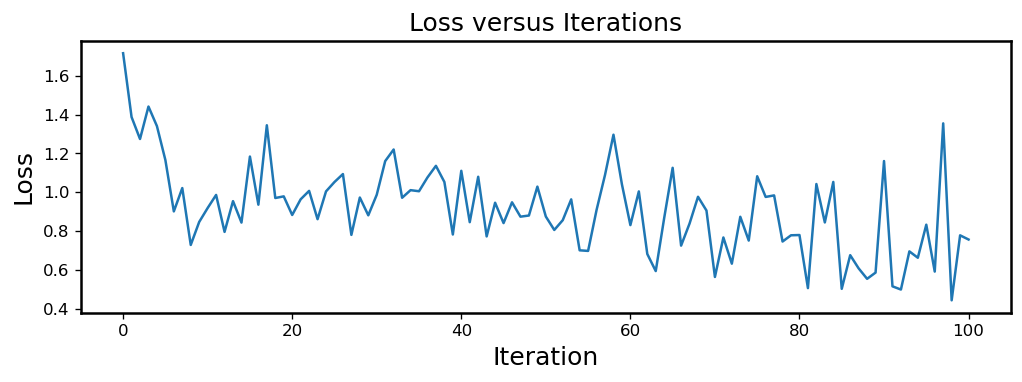

In [33]:
# Plotting the mean rewards and losses per perf_check 

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})

plt.plot(td_loss_history)
plt.title('Loss versus Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Evaluating our Agent

In [34]:
# Evaluation function

def evaluate_mario(n_steps, render, greedy=True):

    rewards = []
    
    # Initialize the environment
    env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, True, True, 4, 'last')
    s = env.reset()
    s = reorder_state(s)
    
    # Generate n_steps of trajectory:
    for t in range(n_steps):
        qvalues = agent.get_qvalues(s)[0]
        
        # Choose action based on best q-value
        a = qvalues.argmax(-1)

        next_state, r, done, _ = env.step([a])
        if render == True:
            env.render()

        rewards.append(r)
        
        s = reorder_state(next_state)
        if done:
            break
    env.close()

    return np.sum(rewards)

In [35]:
print('The agent recieved a total reward in one playthrough of', evaluate_mario(1000, True, True))

C:\Users\chris\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


The agent recieved a total reward in one playthrough of 734.0


Note, because DQN gives a determinsitic policy, we do not need to do multiple and average over them.

# Saving and Reloading the agent

In [39]:
# Saving an agent

torch.save(agent, 'Models/DQN.h5')

In [38]:
# # Loading an agent

# agent = torch.load('Models/DQN_best.h5')

# # Confirming it has the architecture we want
# agent.eval()